# Ghrelin

### Import required packages

In [1]:
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem as ch
from rdkit.Chem import Draw as d
from rdkit import DataStructs
import pandas as pd
from rdkit.Chem import rdMolDescriptors as rdescriptors
from matplotlib.mlab import PCA
import matplotlib.pyplot as plt
import csv
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
import sklearn
from rdkit.Chem import PandasTools, Descriptors, MolFromSmiles
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

### Load data - Ghrelin receptor IC50 bioactivity for *Homo sapiens* (1119 instances with some repeated Id)

In [2]:
with open ('ghrelin.txt', 'r') as f:
    content_raw = list((csv.reader(f, delimiter = '\t')))
len(content_raw)

1120

### Remove duplicated ChEMBL Id's

In [3]:
content=[]
for i in range(0,len(content_raw)):
    if i == 0:
        chembl_id=content_raw[i][0]
        content.append(content_raw[i])
    elif content_raw[i][0]!=chembl_id:
        chembl_id=content_raw[i][0]
        content.append(content_raw[i])

In [4]:
len(content)

872

### Extract useful information

In [5]:
names = []
smiles = []
activity = []
mols = []
for i in range(1,len(content)):
    names.append(content[i][0])
    smiles.append(content[i][5])
    activity.append(content[i][7])
    mols.append(ch.MolFromSmiles(content[i][5]))

### Create proper dataset for further analysis

In [6]:
def HBA(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol)

def HBD(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol)

def logP(mol):
    return Descriptors.MolLogP(mol)

def TPSA(mol):
    return Descriptors.TPSA(mol)

def num_rotatable_bonds(mol):
    return Descriptors.NumRotatableBonds(mol)

def num_heavy_atoms(mol):
    return mol.GetNumHeavyAtoms()

def MW(mol):
    return Descriptors.MolWt(mol)

In [8]:
data=[]
for i,mol in enumerate(mols):
    data.append([names[i], float(activity[i]), HBA(mol), HBD(mol), float(MW(mol)), logP(mol),float(TPSA(mol)),num_rotatable_bonds(mol),num_heavy_atoms(mol),smiles[i]])
dataframe=pd.DataFrame(data,columns=["CHEMBL_ID", "activity", "HBA", "HBD", "MW", "logP", "TPSA","rb","ra",'smiles'])
dataframe.set_index("CHEMBL_ID",inplace=True)

# 1) Run PCA

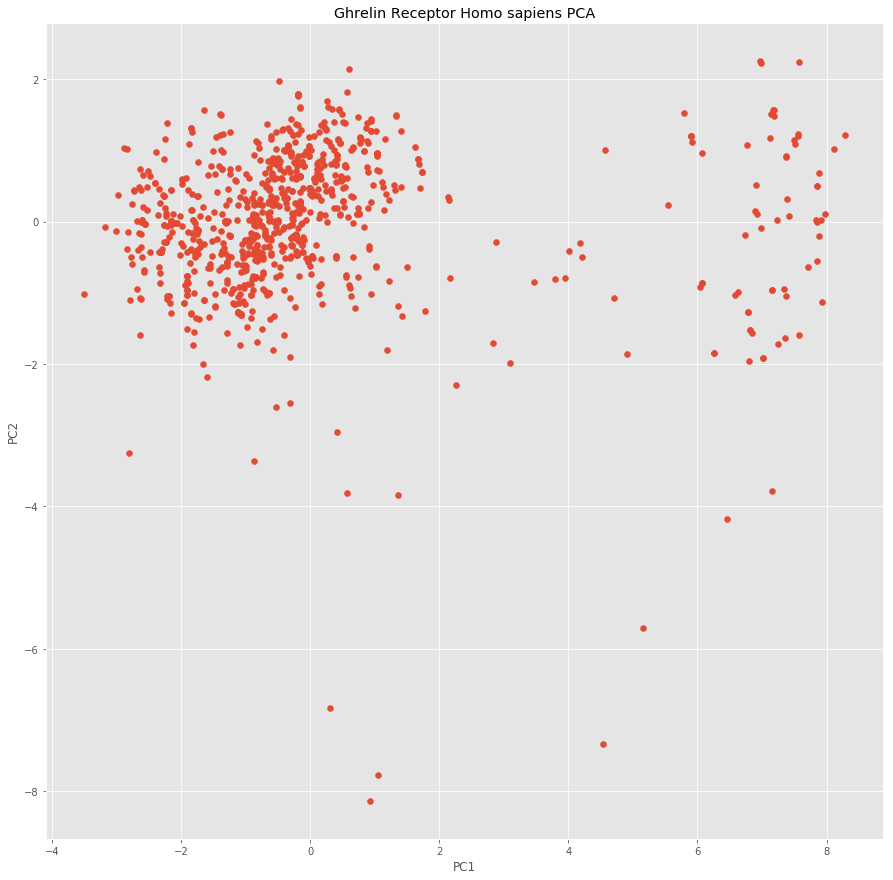

In [9]:
pca1=PCA(dataframe.drop(['smiles'],axis=1))
plt.rcParams["figure.figsize"] = [15, 15]
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Ghrelin Receptor Homo sapiens PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
X = [x[0] for x in pca1.Y]
Y = [y[1] for y in pca1.Y]
plt.scatter(X,Y)
plt.show()

In [10]:
pca1.fracs # with the first two PC we cover 82% of the variance.

array([ 0.69131813,  0.13722188,  0.1099352 ,  0.03620231,  0.01481654,
        0.00715094,  0.00249769,  0.00085731])

# 2) Prepare data for CLUSTERING

In [11]:
ids = list(range(len(content)))
mols_fps = [(m, ch.GetMorganFingerprint(m, 2)) for m in mols]
picker = MaxMinPicker()

def fp_distance(i, j, mols_fps=mols_fps):
    return 1 - DataStructs.TanimotoSimilarity(mols_fps[i][1],
                                              mols_fps[j][1])

pickIndices = picker.LazyPick(fp_distance, len(mols_fps), 500, seed=666)

filtered_mols_fps = [mols_fps[i] for i in pickIndices]
result = filtered_mols_fps


In [12]:
prep_data = [(m, HBA(m), HBD(m), MW(m),logP(m),TPSA(m),num_rotatable_bonds(m),num_heavy_atoms(m)) for m, fp in result]

In [13]:
out = open("for_clustering.csv","w")
out.write("name,HA,HD,mw,lp,tpsa,rb,ha\n")
for m, HA, HD,mw, lp, tpsa, rb, ha in prep_data:
    out.write("%s,%d,%d,%f,%f,%f,%d,%d\n" % (names[mols.index(m)], HA, HD,mw, lp, tpsa, rb, ha))

out.close()

In [14]:
out = open("for_clustering_metadata.csv","w")
out.write("name,activity\n")
mols_prep_data=[]
for m in prep_data:
    mols_prep_data.append(m[0])
for m in mols_prep_data:
    out.write("%s,%s\n" % (names[mols.index(m)], activity[mols.index(m)]))
out.close()

### Create an image from every molecule

In [15]:
result_images = []
for i in range(0,len(smiles)):
    result_images.append([names[i],mols[i]])

In [19]:
for i in range(len(mols)):
    d.MolToFile(mols[i], "molecule_id" +result_images[i][0]+ ".png")

### Create cluster json file

In [16]:
%%bash
python inchlib_clust.py for_clustering.csv -m for_clustering_metadata.csv -dh -mh -o clustering.json 

Clustering rows: euclidean ward
Adding metadata: 500 rows


HTML file created with the name "example.html" I tried to open a new port from here and visualize the cluster without getting outside the code but it gets stuck. Try to fix this!!!

# 3) Activity prediction

### Select useful data for the Random Forest model

In [17]:
model=dataframe.ix[:,["smiles", "activity"]]

In [18]:
desc_list = Descriptors.descList

In [19]:
model["pic50"] = model.activity.apply(lambda x : -1.0 * np.log10(x / 1.0e9))
for desc_name, function in desc_list:
    values = []
    for smiles in model["smiles"]:
        mol = MolFromSmiles(smiles)
        values.append(function(mol))
    model[desc_name] = values 

In [20]:
columns = [x[0] for x in desc_list[:30]]

### Divide data into training data (70%) and testing data (30%)

In [21]:
train_data, test_data = train_test_split(model, test_size=0.3)

### Train the model

In [22]:
model2 = RandomForestRegressor(n_estimators=15)
model2.fit(train_data[columns], train_data["pic50"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

### Run the model with test data

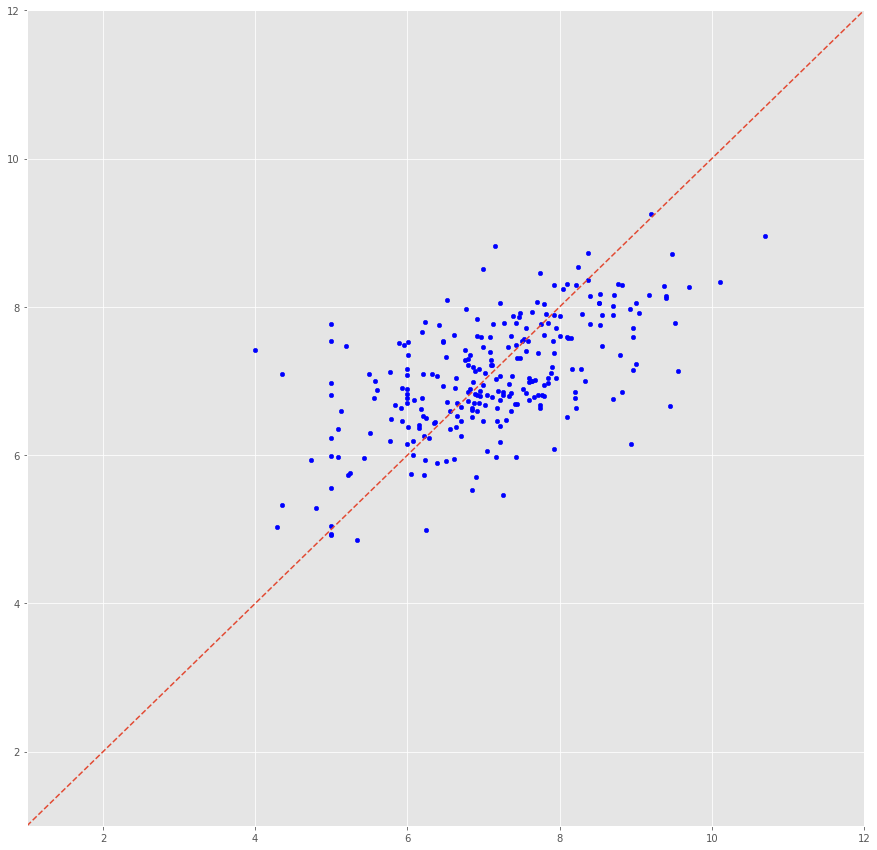

In [23]:
plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

plt.scatter(
    test_data["pic50"]
    , model2.predict(test_data[columns])
    , c='blue'
    , s=20
)
plt.show()

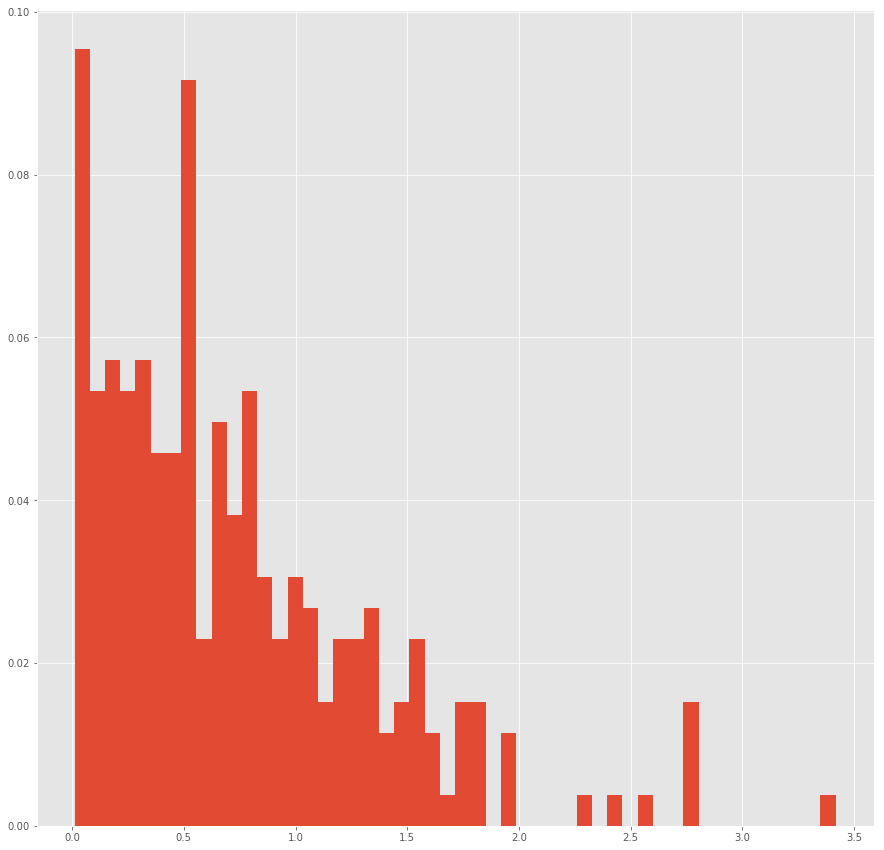

In [24]:
errors = (test_data.pic50 - model2.predict(test_data[columns])).abs()
weights = np.ones_like(errors) / len(errors)
plt.hist(errors, weights=weights, bins=50)
plt.show()

### Accuracy of the model

In [25]:
print("R^2: %0.2f" % model2.score(test_data[columns], test_data.pic50))
print("R: %0.2f" % np.sqrt(model2.score(test_data[columns], test_data.pic50)))
print("MSE: %0.2f" %  mean_squared_error(model2.predict(test_data[columns]), test_data.pic50))

R^2: 0.35
R: 0.59
MSE: 0.90


This model has a bad accuracy. It's not the best option. Let's see if other models can give better results.

## Comparison Random Forest, ADA Boost Regressor and Gradient Boosting Regressor

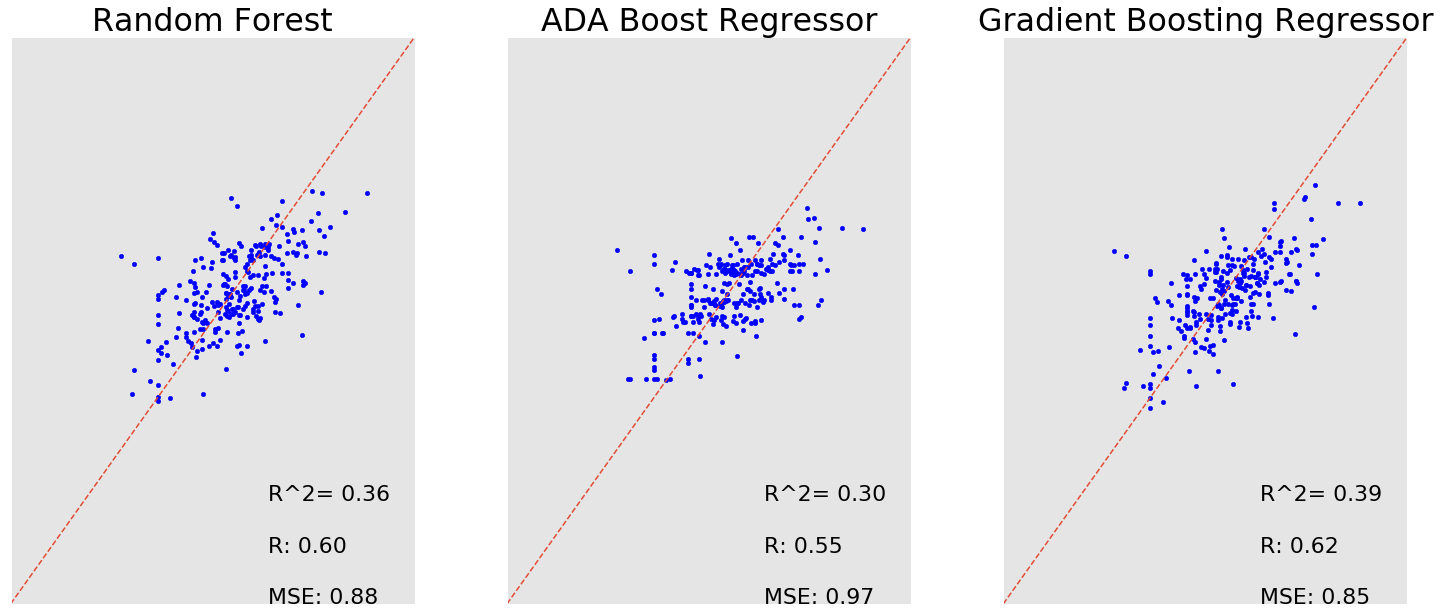

In [29]:
figure = plt.figure(figsize=(27, 9))
plt.rcParams.update({'font.size': 22})
i = 1
names = [ "Random Forest","ADA Boost Regressor","Gradient Boosting Regressor"]
classifiers = [RandomForestRegressor(n_estimators=15), AdaBoostRegressor(),GradientBoostingRegressor()]
# iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(train_data[columns], train_data["pic50"])
    score = clf.score(test_data[columns], test_data["pic50"])
    ax.scatter(test_data["pic50"], clf.predict(test_data[columns]), c='blue', s=20)
    ax = plt.gca()
    ax.set_xlim(1,12)
    ax.set_ylim(1,12)
    ax.text(8,3,"R^2= %0.2f" % clf.score(test_data[columns], test_data.pic50))
    ax.text(8,2,"R: %0.2f" % np.sqrt(clf.score(test_data[columns], test_data.pic50)))
    ax.text(8,1,"MSE: %0.2f" %  mean_squared_error(clf.predict(test_data[columns]), test_data.pic50))
    plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')
    span = (1,12)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    i += 1

plt.tight_layout()
plt.show()

The comparison between 3 different regression models shows that all of them have similar properties. 